## Convolutional Neural Networks (CNNs)
* Künstliche Neuronale Netzwerke haben in ihrer einfachsten Form eine _gigantische_ Menge an Parametern, die gelernt werden können.
* Das ist insofern problematisch, weil (bspw.) der Trainingsaufwand damit drastisch steigt.
* **Beobachtung**: viele Aufgaben weisen eine hohe Regularität auf; so macht es beispielsweise keinen Unterschied, ob sich ein Hund in einem Bild auf der linken oder rechten Seite befindet.
* **Beobachtung**: genauso macht es keinen großen Unterschied, ob der Peak der Wave-Form weiter links oder rechts ist.
* **Idee**: die Parameter, die Peaks links bzw. rechts erkennen, sollten die gleichen sein! Wie kann das umgesetzt werden?


## Convolution
* **Idee**: Layer $F$ im KNN lernt einen _Kernel_ $K$, der mit der _Eingabe_ $I$ gefaltet wird:

    $$F(i,j) = (I \ast K)(i,j) = \sum_m \sum_n I(m,n) K(i-m,j-n)$$

* $F$ ist hier für den zweidimensionalen Fall gegeben (z.B. für Bilder).
* $I$ ist dann das Eingabebild (2d-Matrix) und $K$ der gelernte Kernel (auch 2d-Matrix) ($I$ in grün, $K$ in gelb, $F$ in rot):

![Convolution](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)
Quelle: http://deeplearning.stanford.edu

* Damit ist die Anzahl der Parameter in $F$ nur noch von der Größe von $K$ abhängig!
* Diese Idee führt erst dazu, dass die Aufgabe der Bildverarbeitung überhaupt machbar wird.

---
### Falten eines Sobel-Kernels (vertikale Kantenerkennung) mit einem Eingabebild:

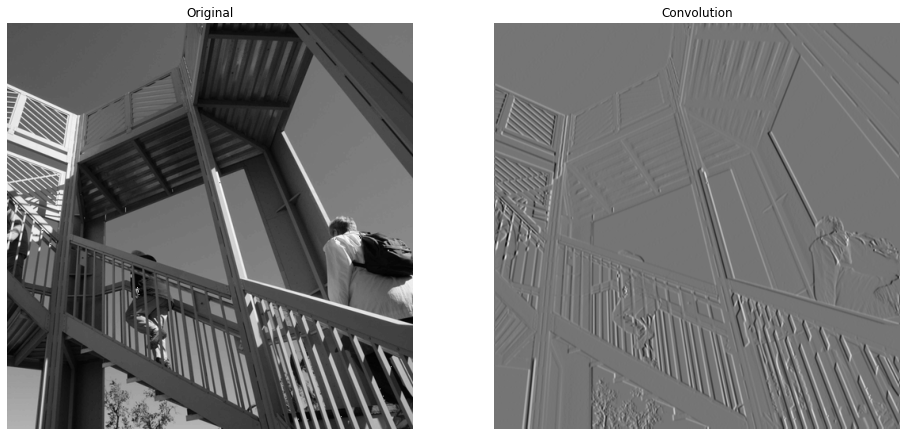

In [1]:
# source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html
import numpy as np
from scipy import signal
from scipy import misc

picture = misc.ascent()
# sobel operator (vertical edge detection) (https://de.wikipedia.org/wiki/Sobel-Operator)
kernel = np.array([[ -1, 0, 1],
                   [ -2, 0, 2],
                   [ -1, 0, 1]])
# convolve picture w/ kernel
conv = signal.convolve2d(picture, kernel, boundary='symm')

import matplotlib.pyplot as plt
fig, (ax_orig, ax_conv) = plt.subplots(1, 2, figsize=(16, 15))
ax_orig.imshow(picture, cmap="gray")
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_conv.imshow(conv, cmap="gray")
ax_conv.set_title('Convolution')
ax_conv.set_axis_off()

## Pooling
* **Problem**: Die Anwendung einer Faltung allein reduziert noch nicht die Größe der Eingabe.
* **Idee**: Aus lokalen Gruppen an Neuronen (bspw. der Größe 2x2) wird nur das Signal weitergeleitet, das am stärksten ist:

![Max Pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)
Quelle: Wikipedia/Aphex34

* Das führt zu einer deutlichen Reduktion der Dimension der Eingabe.

---
### Reduktion der Eingabedimension via Max-Pooling:

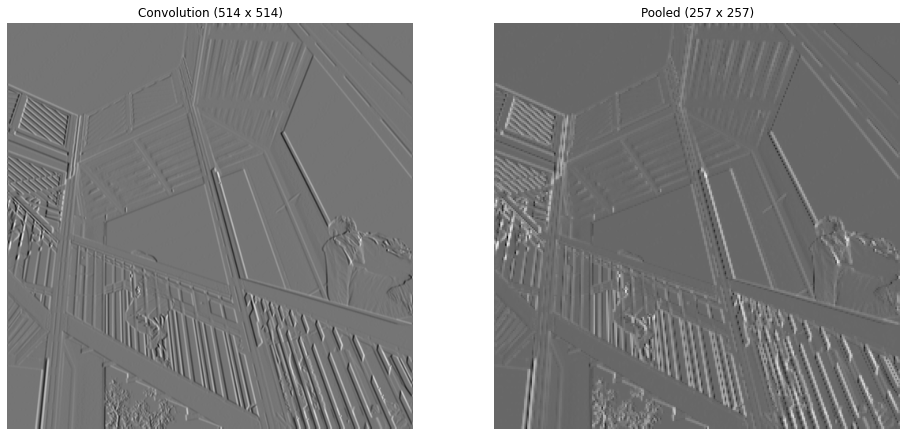

In [2]:
def maxpool(I, reduction):
    pooled = np.zeros((I.shape[0]//reduction, I.shape[1]//reduction))
    for i,j in np.ndindex(pooled.shape[0], pooled.shape[1]):
        pooled[i,j] = np.max(I[i*reduction:(i+1)*reduction, j*reduction:(j+1)*reduction])
    return pooled

pooled = maxpool(conv, 2)

fig, (ax_conv, ax_pool) = plt.subplots(1, 2, figsize=(16, 15))
ax_conv.imshow(conv, cmap="gray")
ax_conv.set_title('Convolution (%s x %s)' % conv.shape)
ax_conv.set_axis_off()
ax_pool.imshow(pooled, cmap="gray")
ax_pool.set_title('Pooled (%s x %s)' % pooled.shape)
ax_pool.set_axis_off()

## Aufbau eines CNN
* Typischerweise wird mit einem "Convolutional Layer" ein Ensemble aus
    * der Faltung,
    * dem Anwenden einer nichtlinearen Aktivierungsfunktion und
    * dem Pooling gemeint.
* Ein CNN besteht dann aus einem Eingabelayer, mindestens einem convolutional Layer und einem vollständig vernetzten KNN am Ende, welches die Daten weiter verarbeiten kann.
    
<img src="https://www.asimovinstitute.org/wp-content/uploads/2016/09/cnn.png" width=400>
Quelle: https://www.asimovinstitute.org/neural-network-zoo

* Gelb: Eingabe,
* Pink: Convolution,
* Pink mit Kreis: Convolution + Pooling,
* Grün: Hidden Neurons,
* Rot: Ausgabe.

In [3]:
import pandas as pd
import numpy as np

import sys
sys.path.append("..")
sys.path.append("../utils")
import utils

# read and process dataset
data = utils.load_dataset("../data/mit_Uferuebergang/all_data_edit.txt")
# print head of the dataframe
data[0:5]

,id,class,x,y,z,0,1,2,3,4,...,190,191,192,193,194,195,196,197,198,199
0,1114,1,-19.952490,-112.538942,0.137429,149,145,146,142,150,...,0,0,0,0,0,0,0,0,0,0
1,1115,1,-19.855479,-112.473813,0.126430,146,140,146,144,149,...,0,0,0,0,0,0,0,0,0,0
2,1117,1,-19.655191,-112.334737,0.091433,145,142,145,142,148,...,0,0,0,0,0,0,0,0,0,0
3,1118,1,-19.548943,-112.261880,0.072435,146,147,149,144,146,...,0,0,0,0,0,0,0,0,0,0
4,1119,1,-20.005788,-113.214739,0.051417,151,151,148,142,150,...,0,0,0,0,0,0,0,0,0,0


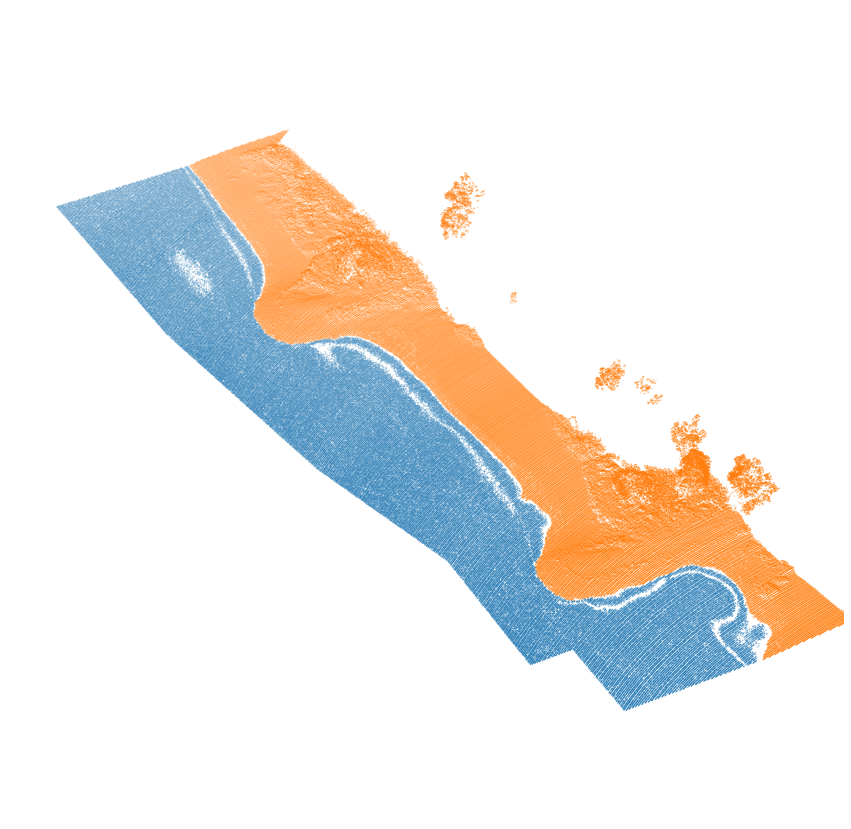

In [4]:
# 3d-plot of the point cloud
utils.plot_pcl(data, plotsize=15)

* Ab sofort wird das Python-Modul `pytorch` für alle KNN-relevanten Aufgaben verwendet.

## Aufbau des CNN
* Wir definieren jetzt ein einfaches CNN, das die Wave-Forms klassifizieren soll.
* Das Netzwerk hat eine Eingangsdimension von 64, die die ersten 64 Samples der Wave-Form darstellen sollen.
* Darauf folgen jeweils zwei Convolutional Layer, die jeweils
    * 8 Kernel definieren,
    * mit ReLU als Aktivierungsfunktion (mit $ReLU(x) = \max(0,x)$)
    * und einem Max-Pooling Layer, welches die Eingabedimension um den Faktor 2 reduziert.
* Am Ende des Netzwerks steht ein vollständig vernetztes Layer, welches die Ausgabe des Netzwerks berechnet:

In [5]:
import torch
from torch import nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # input dimension: 64
        # after layer1 ~ 32
        # after layer2 ~ 16
        
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=5, stride=1, padding=2),  # convolution w/ 8 different kernels
            nn.ReLU(),                                            # non-linear activation function
            nn.MaxPool1d(kernel_size=2, stride=2))                # pooling. stride == amount of reduction
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(8, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        
        self.fc1 = nn.Linear(8*16, 2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [6]:
from torch.utils.data import DataLoader, Dataset, random_split

class WaveFormDataset(Dataset):
    def __init__(self, data):
        self.xs = utils.waveforms_as_matrix(data)
        self.xs = self.xs[:,:64]/200 # cut off and normalize
        self.xs = torch.tensor(self.xs).float() # to tensor
        self.labels = torch.tensor(data["class"].to_numpy())

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample = { "waveform" : self.xs[idx], "label" : self.labels[idx] }
        
        return sample

dataset = WaveFormDataset(data)
p = 0.9
train_size = int(len(dataset)*p)
train_dataset, test_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

## Training
* Dazu verwenden wir folgende Parameter:
    * Als Kostenfunktion wird die [Kreuzentropie](https://de.wikipedia.org/wiki/Kreuzentropie) verwendet,
    * als Optimierungsverfahren Stochastic Gradient Descent (SGD)
    * und Haltekriterium ist eine Kombination aus einer maximalen Anzahl an Iterationen und stärke der Konvergenz: 

In [7]:
model = ConvNet()

batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.07)

num_epochs = 10

loss_list = []
acc_list = []
acc_test_list = []

for epoch in range(num_epochs):
    meanloss = 0
    for i, d in enumerate(train_loader):
        waveforms, labels = d["waveform"], d["label"]
        waveforms = waveforms.unsqueeze(1)
        
        # Run the forward pass
        outputs = model(waveforms)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        
        meanloss = meanloss + (loss.item() - meanloss)/(i+1)
        
        if (i + 1) % 100 == 0:
            # test accuracy
            acc_test_dataset = test_dataset[:]
            test_output = model(acc_test_dataset["waveform"].unsqueeze(1))
            _, test_pred = torch.max(test_output.data, 1)
            test_correct = (test_pred == acc_test_dataset["label"]).sum().item()
            acc_test_list.append(test_correct / acc_test_dataset["label"].size(0))
            
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f} Test Accuracy: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, train_size//batch_size, loss.item(),
                          acc_list[-1], acc_test_list[-1]))
            
    print("mean loss / epoch: {:.4f}".format(meanloss))
    if meanloss <= 0.005:
        break

Epoch [1/10], Step [100/1926], Loss: 0.5467, Accuracy: 0.6875 Test Accuracy: 0.7131
Epoch [1/10], Step [200/1926], Loss: 0.1555, Accuracy: 0.9688 Test Accuracy: 0.9846
Epoch [1/10], Step [300/1926], Loss: 0.0253, Accuracy: 0.9922 Test Accuracy: 0.9928
Epoch [1/10], Step [400/1926], Loss: 0.0117, Accuracy: 1.0000 Test Accuracy: 0.9937
Epoch [1/10], Step [500/1926], Loss: 0.0242, Accuracy: 0.9922 Test Accuracy: 0.9955
Epoch [1/10], Step [600/1926], Loss: 0.0096, Accuracy: 0.9922 Test Accuracy: 0.9958
Epoch [1/10], Step [700/1926], Loss: 0.0062, Accuracy: 1.0000 Test Accuracy: 0.9966
Epoch [1/10], Step [800/1926], Loss: 0.0023, Accuracy: 1.0000 Test Accuracy: 0.9966
Epoch [1/10], Step [900/1926], Loss: 0.0062, Accuracy: 1.0000 Test Accuracy: 0.9971
Epoch [1/10], Step [1000/1926], Loss: 0.0024, Accuracy: 1.0000 Test Accuracy: 0.9972
Epoch [1/10], Step [1100/1926], Loss: 0.0535, Accuracy: 0.9922 Test Accuracy: 0.9959
Epoch [1/10], Step [1200/1926], Loss: 0.0018, Accuracy: 1.0000 Test Accura

Epoch [6/10], Step [200/1926], Loss: 0.0020, Accuracy: 1.0000 Test Accuracy: 0.9978
Epoch [6/10], Step [300/1926], Loss: 0.0039, Accuracy: 1.0000 Test Accuracy: 0.9982
Epoch [6/10], Step [400/1926], Loss: 0.0018, Accuracy: 1.0000 Test Accuracy: 0.9984
Epoch [6/10], Step [500/1926], Loss: 0.0008, Accuracy: 1.0000 Test Accuracy: 0.9984
Epoch [6/10], Step [600/1926], Loss: 0.0005, Accuracy: 1.0000 Test Accuracy: 0.9983
Epoch [6/10], Step [700/1926], Loss: 0.0264, Accuracy: 0.9922 Test Accuracy: 0.9982
Epoch [6/10], Step [800/1926], Loss: 0.0082, Accuracy: 0.9922 Test Accuracy: 0.9982
Epoch [6/10], Step [900/1926], Loss: 0.0005, Accuracy: 1.0000 Test Accuracy: 0.9973
Epoch [6/10], Step [1000/1926], Loss: 0.0020, Accuracy: 1.0000 Test Accuracy: 0.9981
Epoch [6/10], Step [1100/1926], Loss: 0.0014, Accuracy: 1.0000 Test Accuracy: 0.9984
Epoch [6/10], Step [1200/1926], Loss: 0.0008, Accuracy: 1.0000 Test Accuracy: 0.9984
Epoch [6/10], Step [1300/1926], Loss: 0.0006, Accuracy: 1.0000 Test Accur

Text(0.5, 1.0, 'Accuracy (Testing)')

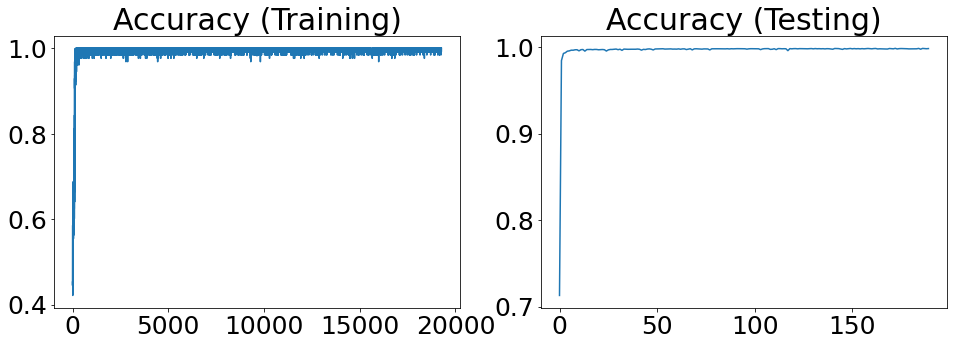

In [8]:
fig, (ax_acc, ax_test_acc) = plt.subplots(1, 2, figsize=(16, 5))
ax_acc.plot(range(len(acc_list)), acc_list)
ax_acc.set_title('Accuracy (Training)')
ax_test_acc.plot(range(len(acc_test_list)), acc_test_list)
ax_test_acc.set_title('Accuracy (Testing)')

In [9]:
# validation
data_val = utils.load_dataset("../data/Elbabschnitt/all_data_edit.txt")
dataset_val = WaveFormDataset(data_val)

## Performance
* Wir können ein paar Eigenschaften feststellen:
    * Selbst dieses kleine CNN konvergiert sehr schnell (sprich: geringer Trainingsaufwand).
    * Durch die geringe Größe des Netzwerks ist es möglich, ohne GPU zu trainieren.
    
---
## Auf anderen Datensätzen
* Dazu laden wir einen der anderen Datensätze und tauschen die "realen" Klassen mit den Vorhersagen des Modells:

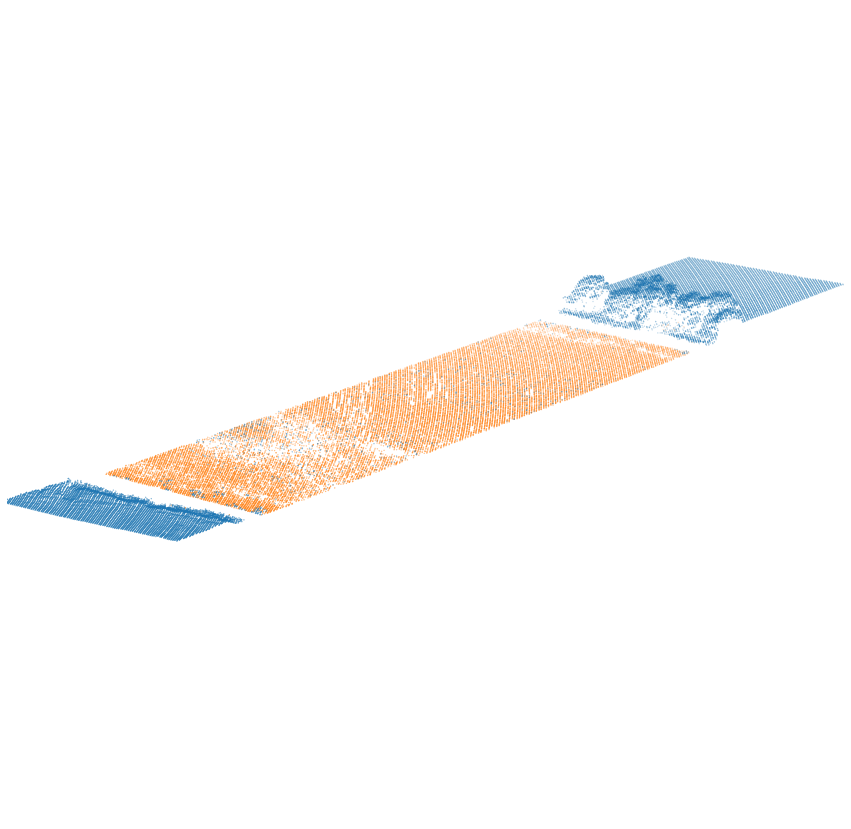

In [10]:
wf = dataset_val[:]["waveform"].unsqueeze(1)
output = model(wf)
_, predicted = torch.max(output.data, 1)
for idx in range(len(data_val)):
    data_val.at[idx, "class"] = predicted[idx].item()
# 3d-plot of the point cloud
utils.plot_pcl(data_val, plotsize=15)

Das Ergebniss scheint vielversprechend zu sein, allerdings scheint es vor allem im Wasser einige Fehldetektionen zu geben.